# Final Project: Classifiying Cat Breeds

In this final project, we will use Pytorch to build an image classifier that can identify different breeds of cats. We will use the [Cat Breeds Dataset](https://www.kaggle.com/datasets/yapwh1208/cats-breed-dataset/code) from Kaggle. Although a small dataset, we will train it on the available computing resources (on an Apple laptop) This dataset contains 1200 images of 5 different cat breeds. 

We will use this dataset to train a convolutional neural network to classify the different breeds of cats.

## Import the important packages

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Load the data

we will load the data, transform it into tensors, and normalize it. We will also split the data into training, validation, and test sets. we will also define the nerual network architecture in the following code block.

In [10]:
# Check if GPU is available and use CPU otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations for the image
transform = transforms.Compose(
    [transforms.Resize((256, 256)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the dataset
full_dataset = torchvision.datasets.ImageFolder(root='cat_v1/', transform=transform)

# Splitting the dataset into train and test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

# Define a simple CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 61 * 61, 120)  # Adjust input size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)  # 5 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 61 * 61)  # Adjust input size
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Exporatory Data Analysis

we will make some visualizations to understand the data better.

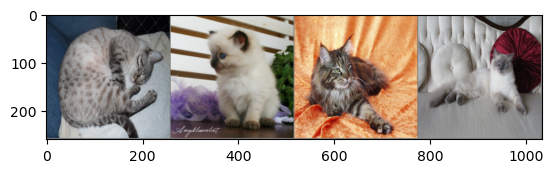

Labels: bengal ragdoll maine_coon ragdoll


In [21]:
import os
import numpy as np


# Load the dataset
dataset = ImageFolder(root='cat_v1/', transform=transform)

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# Get some random training images
dataiter = iter(torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True))
images, labels = next(dataiter)  # Corrected this line

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
classes = dataset.classes
print('Labels:', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


## Training the model

Next, we will define the loss function using the cross entropy loss and the optimizer using the stochastic gradient descent. We will then train the model for 10 epochs and save the model with the lowest validation loss. We can train the model for more epochs if we have more computing resources.

In [8]:
net = Net().to(device)

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


In [12]:
# Lists for storing metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# Train the network
num_epochs = 5
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)
    
    train_accuracy = calculate_accuracy(trainloader, net)
    train_accuracies.append(train_accuracy)

    test_loss = sum(criterion(net(images.to(device)), labels.to(device)).item() for images, labels in testloader) / len(testloader)
    test_losses.append(test_loss)

    test_accuracy = calculate_accuracy(testloader, net)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs} - Train loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

print('Finished Training')

Epoch 1/5 - Train loss: 0.0082, Train Accuracy: 99.74%, Test Loss: 0.0286, Test Accuracy: 98.95%
Epoch 2/5 - Train loss: 0.0077, Train Accuracy: 99.74%, Test Loss: 0.0328, Test Accuracy: 98.95%
Epoch 3/5 - Train loss: 0.0069, Train Accuracy: 99.74%, Test Loss: 0.0410, Test Accuracy: 98.43%
Epoch 4/5 - Train loss: 0.0060, Train Accuracy: 99.74%, Test Loss: 0.0278, Test Accuracy: 98.43%
Epoch 5/5 - Train loss: 0.0055, Train Accuracy: 99.74%, Test Loss: 0.0312, Test Accuracy: 97.91%
Finished Training


The follwing script will save the model weights to a file

In [13]:
# Save the trained model
PATH = './cats_net.pth'
torch.save(net.state_dict(), PATH)

## Visualize the results

we will visualize the training and validation loss and accuracy to see how the model performed.

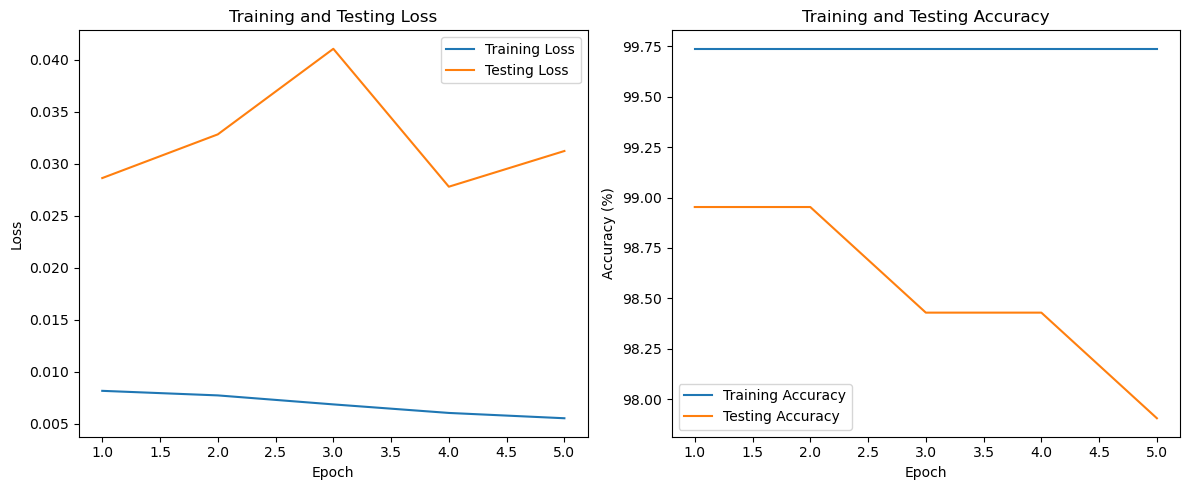

In [14]:
# Plotting the training and testing metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Test the model

Finally, we will test the model on the test set and see how it performs on the unseen data.

In [18]:
from PIL import Image

# Function to preprocess the image
def process_image(image_path):
    # Define the same transformations as before
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Apply the transformations to the image
    image_tensor = transform(image).float()

    # Add an extra batch dimension since pytorch treats all inputs as batches
    image_tensor = image_tensor.unsqueeze_(0)

    return image_tensor

# Function to predict the class of an image
def predict_image(image_path, model, device):
    image_tensor = process_image(image_path).to(device)
    
    # Predict the class of the image
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs.data, 1)
    
    return predicted.item()

# Load the model
model = Net()
model.load_state_dict(torch.load('cats_net.pth'))
model.to(device)
model.eval()  # Set the model to evaluation mode


Predicted class: domestic_shorthair


I will now let the model to predict, my cat which is a canadian domestic shorthair. First, I will show it the image of my cat and then I will let it predict the breed of my cat.

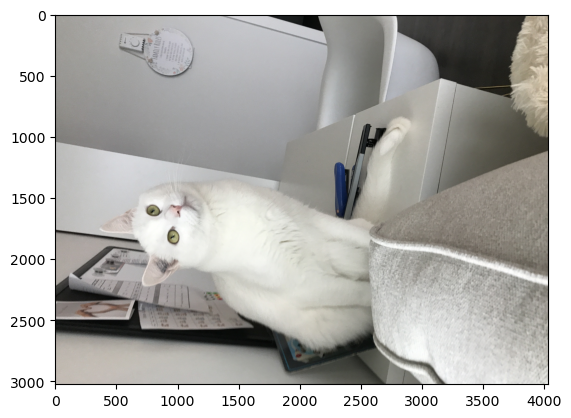

In [23]:
image_path = 'my_cat.JPG' 
image = Image.open(image_path)
plt.imshow(image)

In [22]:
predicted_class_index = predict_image(image_path, model, device)
predicted_class = full_dataset.classes[predicted_class_index]

print("Predicted class:", predicted_class)

Predicted class: domestic_shorthair


In [24]:
predicted_class_index = predict_image('my_cat2.jpg', model, device)
predicted_class = full_dataset.classes[predicted_class_index]

print("Predicted class:", predicted_class)

Predicted class: siamese


In [25]:
predicted_class_index = predict_image('my_cat3.jpg', model, device)
predicted_class = full_dataset.classes[predicted_class_index]

print("Predicted class:", predicted_class)

Predicted class: siamese
